# Jax longtogeny for WT mice

In [62]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from aging.behavior.syllables import relabel_by_usage
from sklearn.decomposition import PCA
from aging.df_util import get_index
from toolz import sliding_window

In [15]:
age_index = get_index(level='age')

In [2]:
def get_name(name):
    return re.search(r'\d{5}', name).group()

In [25]:
def get_ont_map():
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/longtogeny_males_clean_v2.parquet"
    )
    _, umap = relabel_by_usage(df, return_map=True)
    return umap

In [26]:
syll_map = get_ont_map()

In [32]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/jax_longtogeny_syllable_df_v00.parquet"
)
df['relabeled_syllables'] = df['syllables'].map(syll_map)

name_map = {k: get_name(k) for k in df["subject_name"].unique()}
df["mouse"] = df["subject_name"].map(name_map)

In [7]:
version = 8
path = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_v02.parquet")

ont_df = pd.read_parquet(path)

In [88]:
long_df = pd.read_parquet(path.with_name("longtogeny_males_clean_v2.parquet"))

In [28]:
usages = (
    df.query("onsets")
    .groupby(["mouse", "age"])["relabeled_syllables"]
    .value_counts(normalize=True)
)
usage_mtx = pd.pivot_table(
    usages.reset_index(),
    values="proportion",
    columns="relabeled_syllables",
    index=["age", "mouse"],
    fill_value=0,
).sort_index(level=[0, 1])

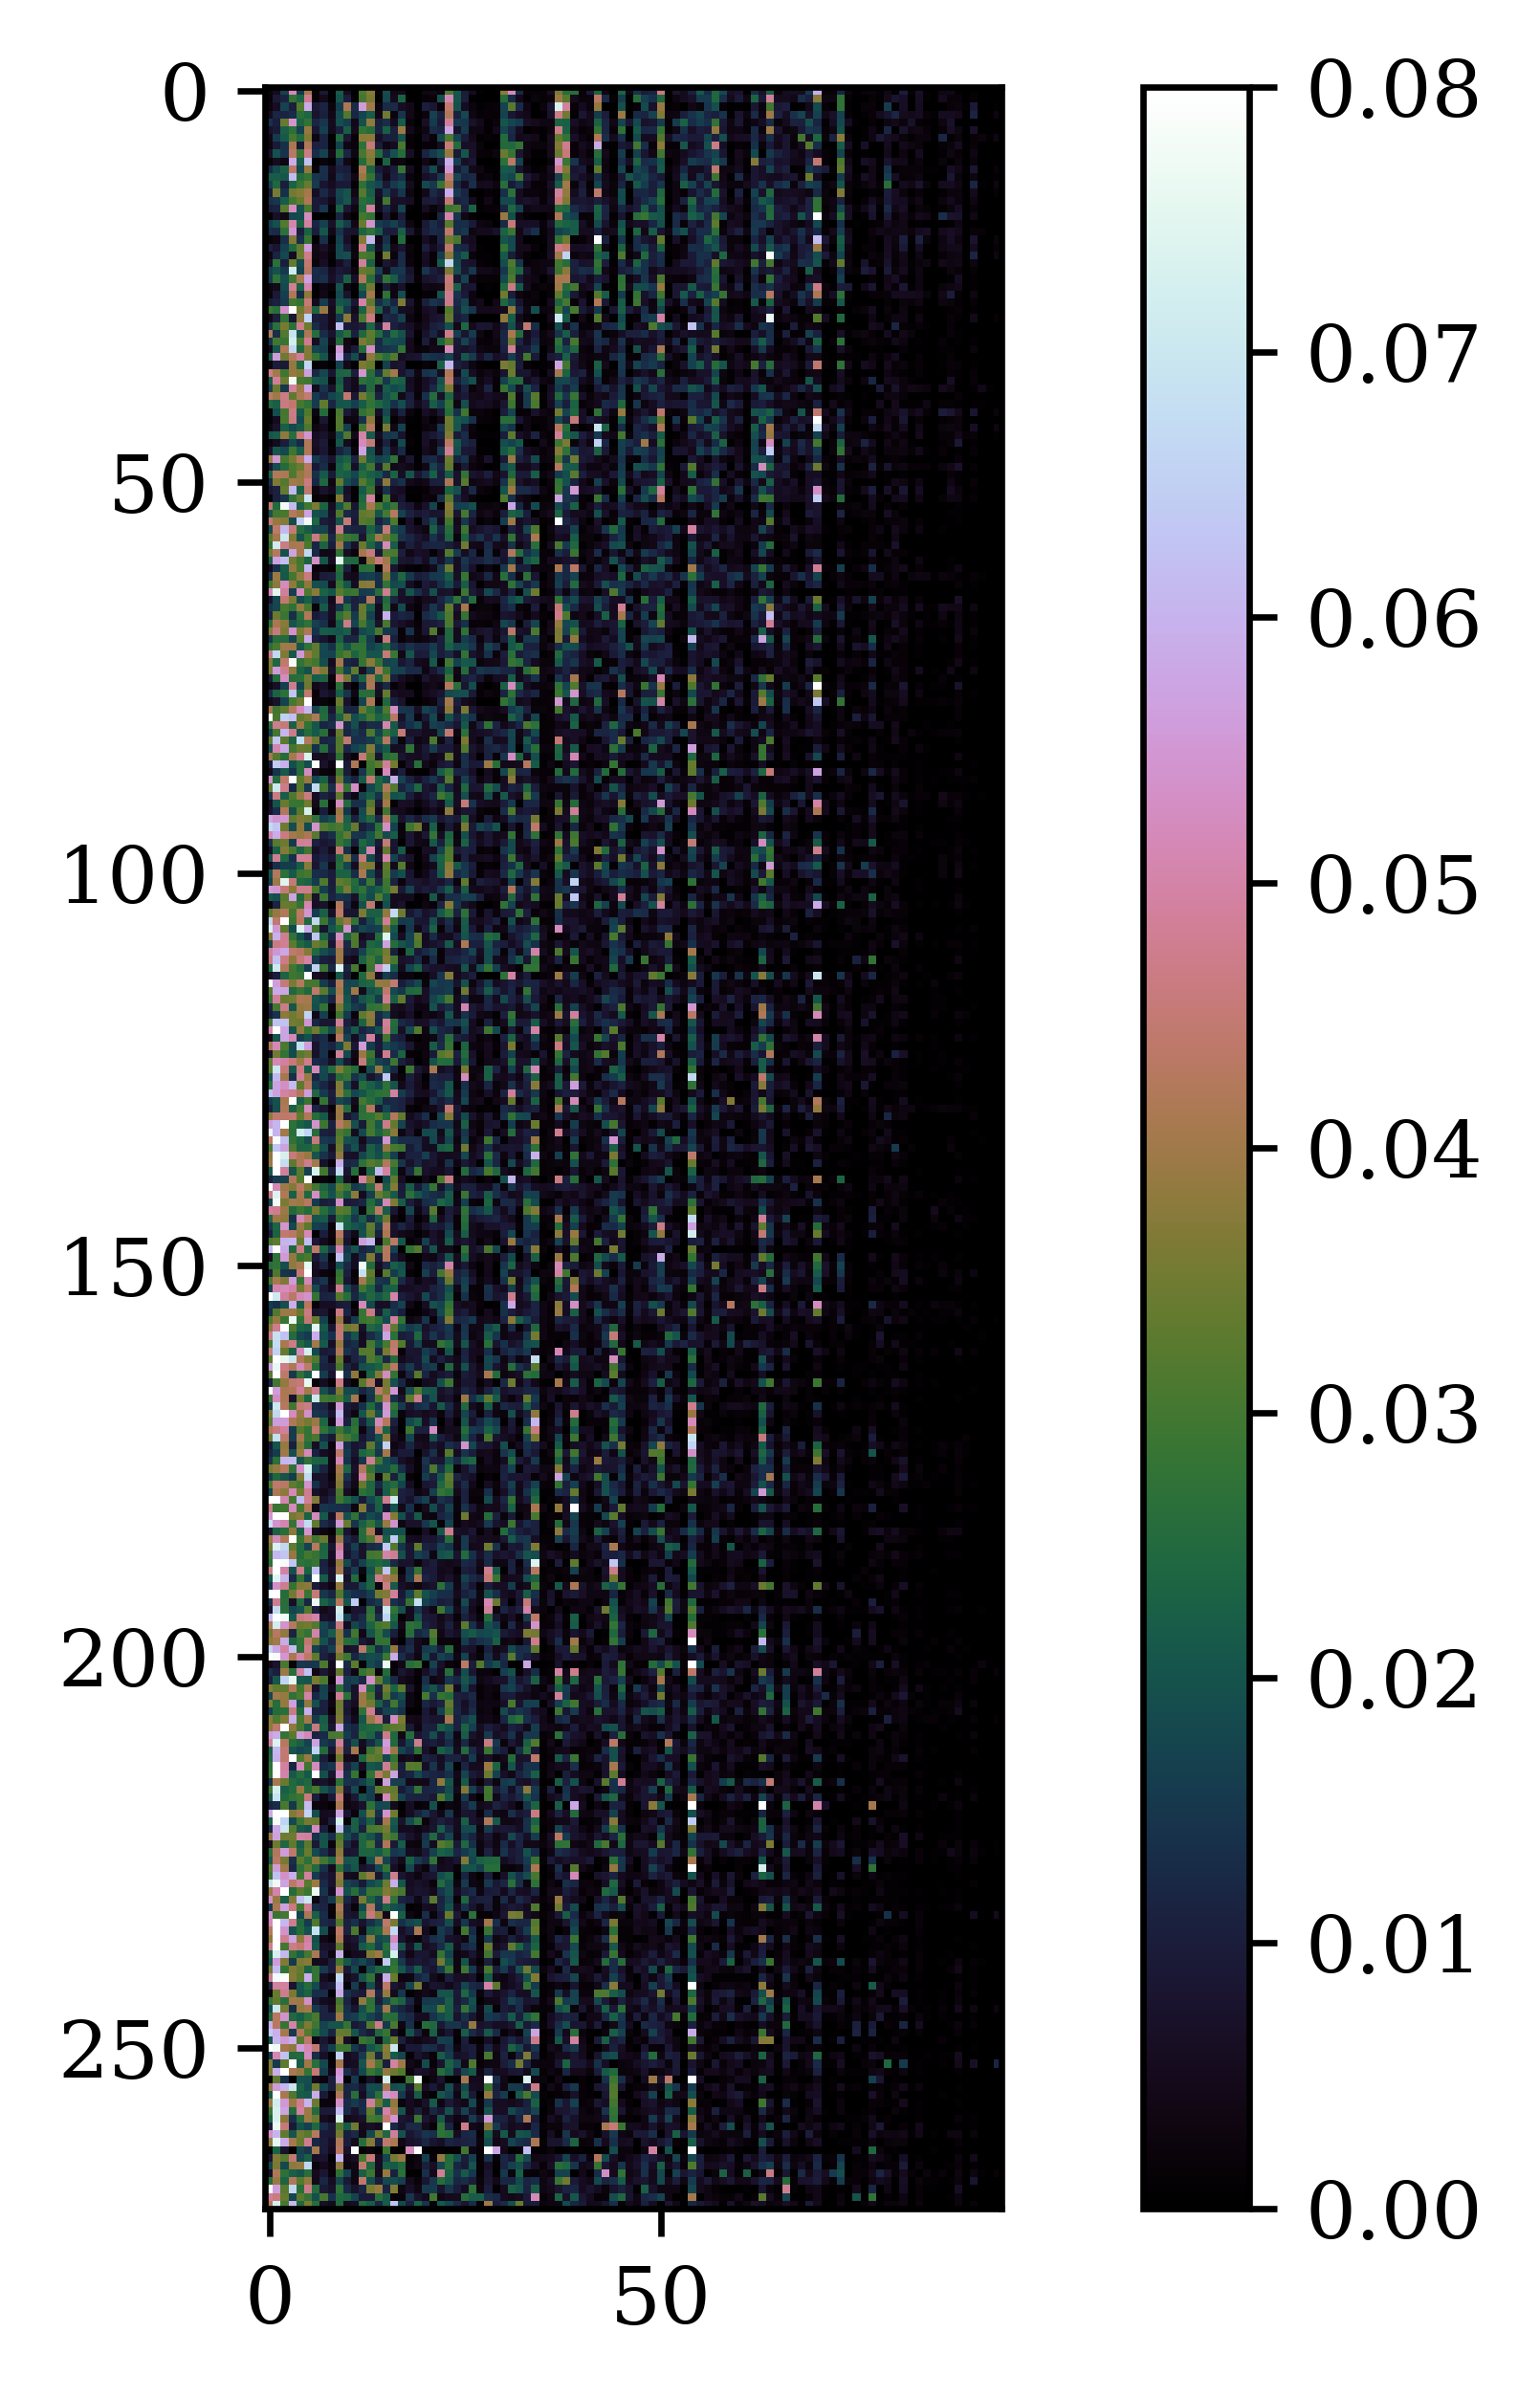

In [29]:
plt.imshow(usage_mtx, cmap='cubehelix', vmax=0.08)
plt.colorbar()

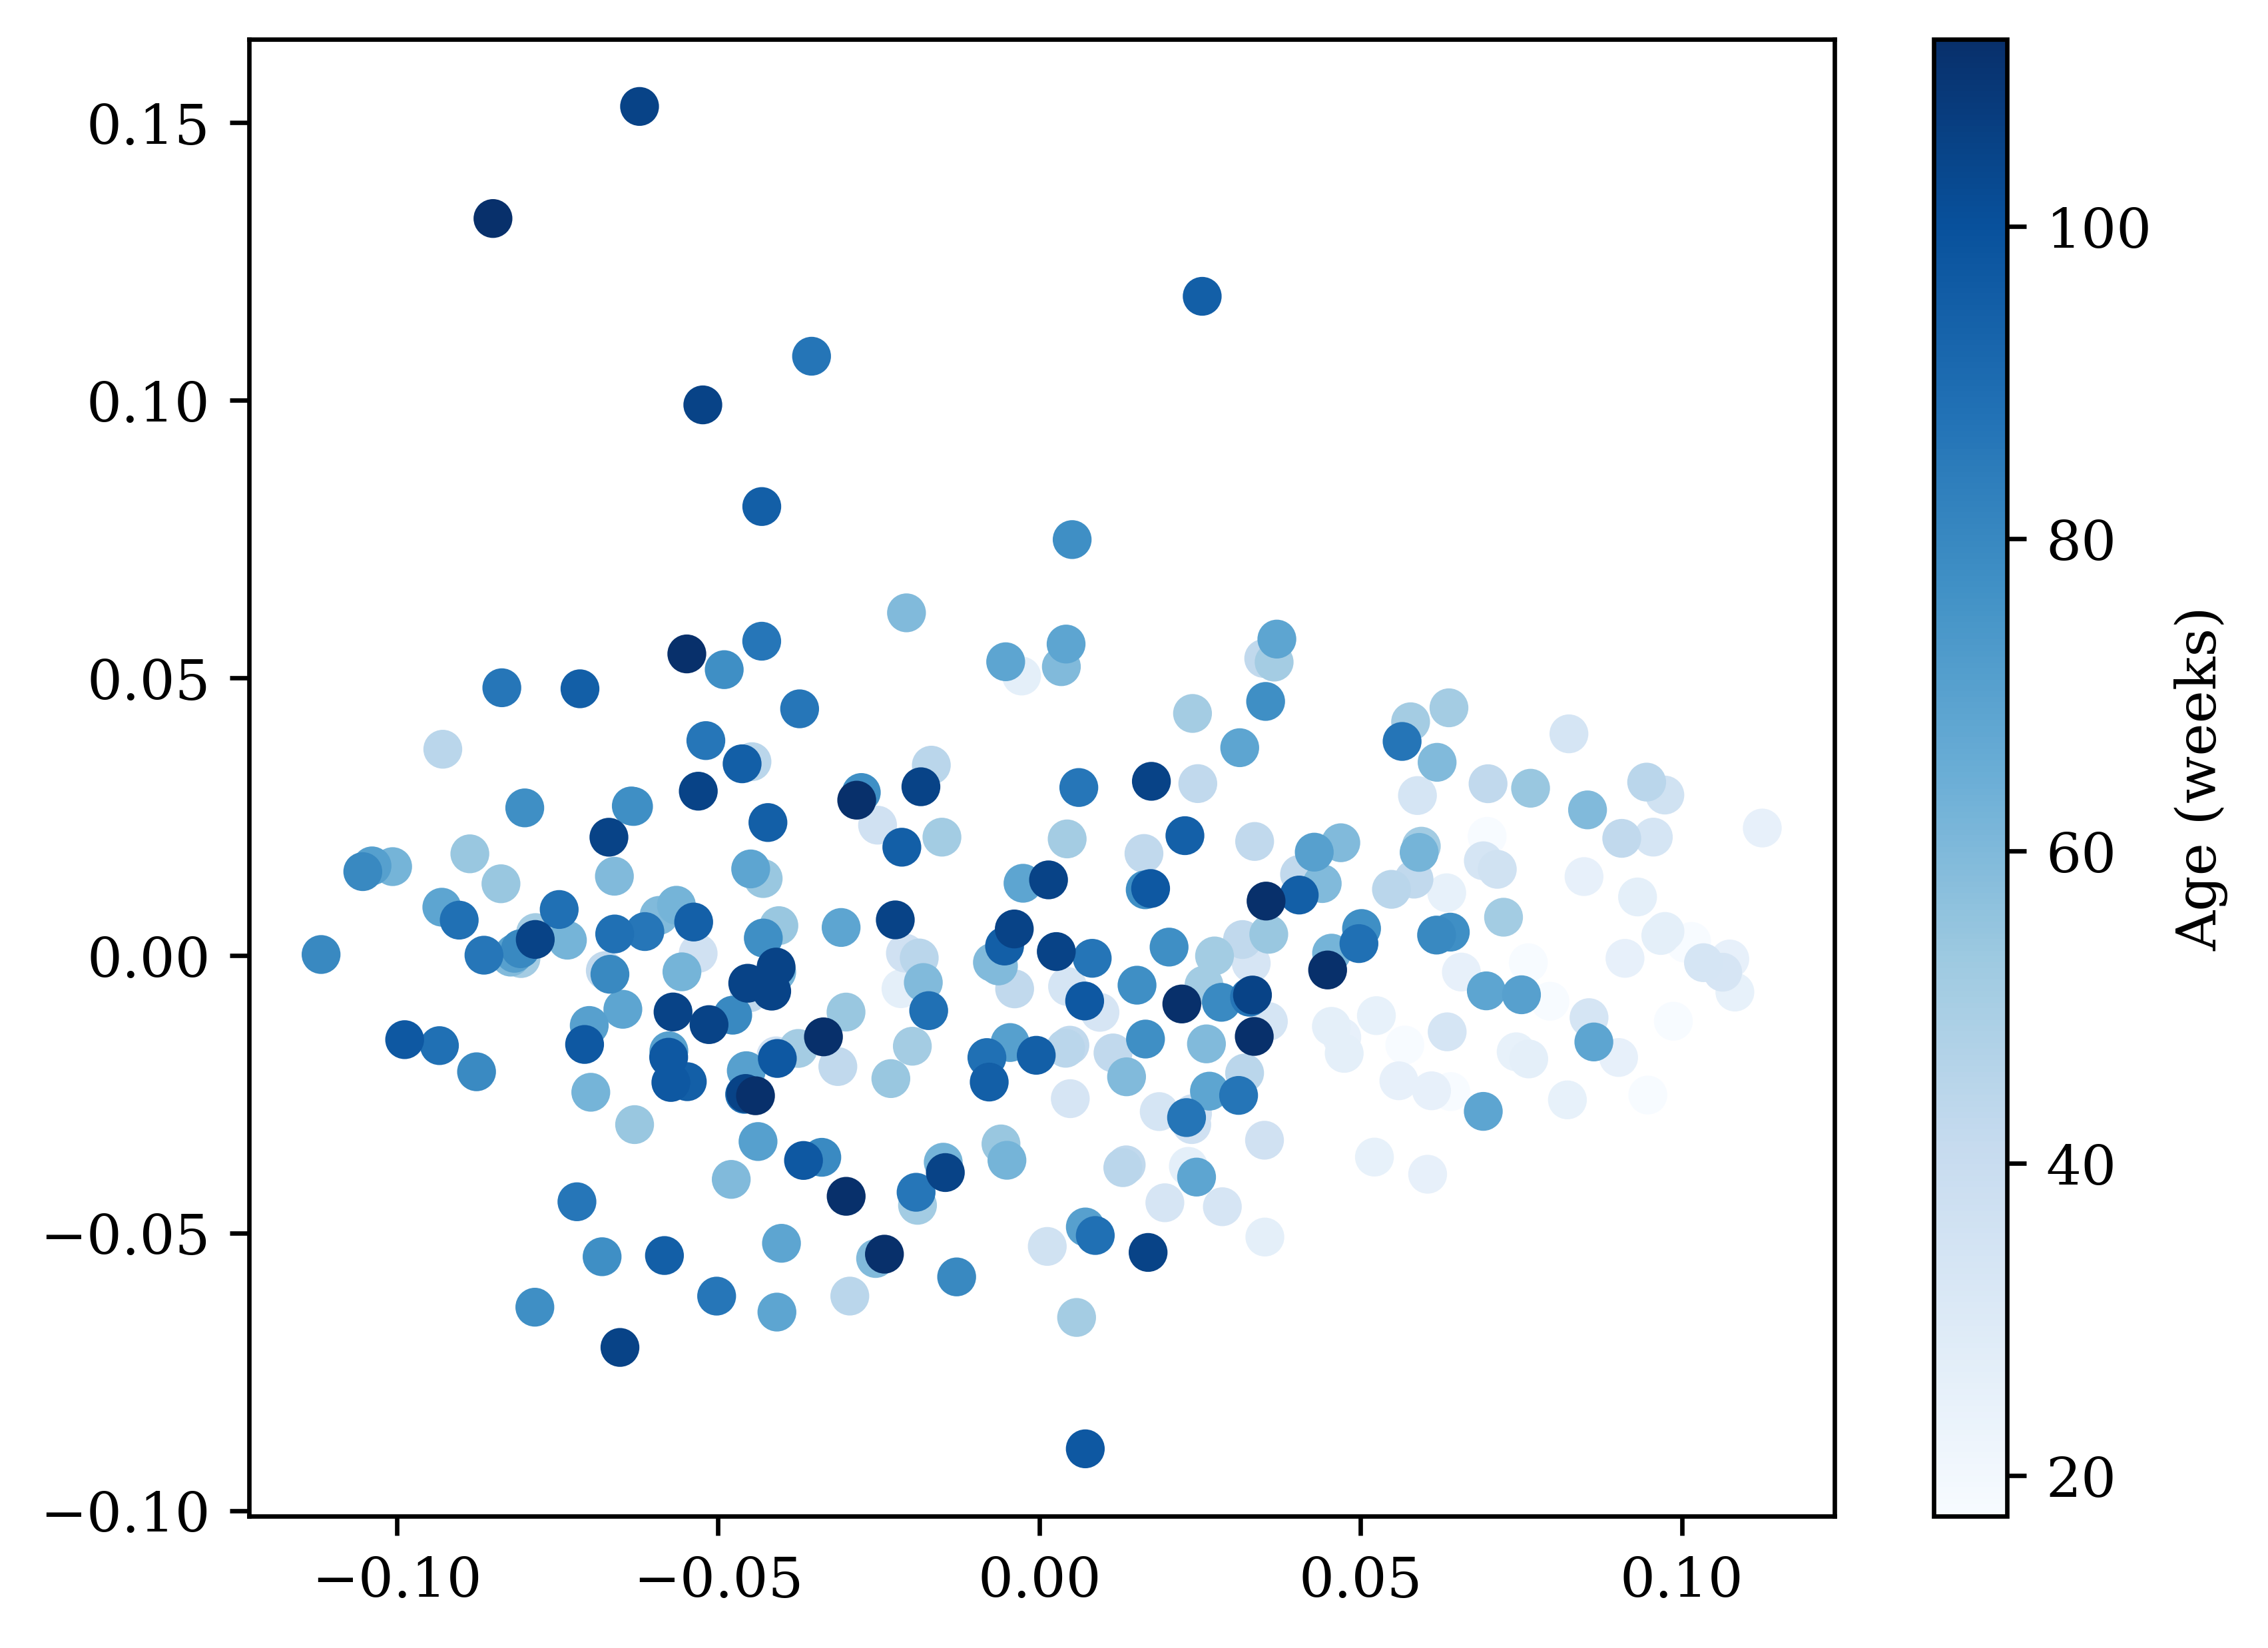

In [30]:
latents = PCA(n_components=2).fit_transform(usage_mtx)
plt.scatter(*latents.T, c=age_index(usage_mtx), cmap='Blues')
plt.colorbar(label='Age (weeks)')

Text(0, 0.5, 'Age (weeks)')

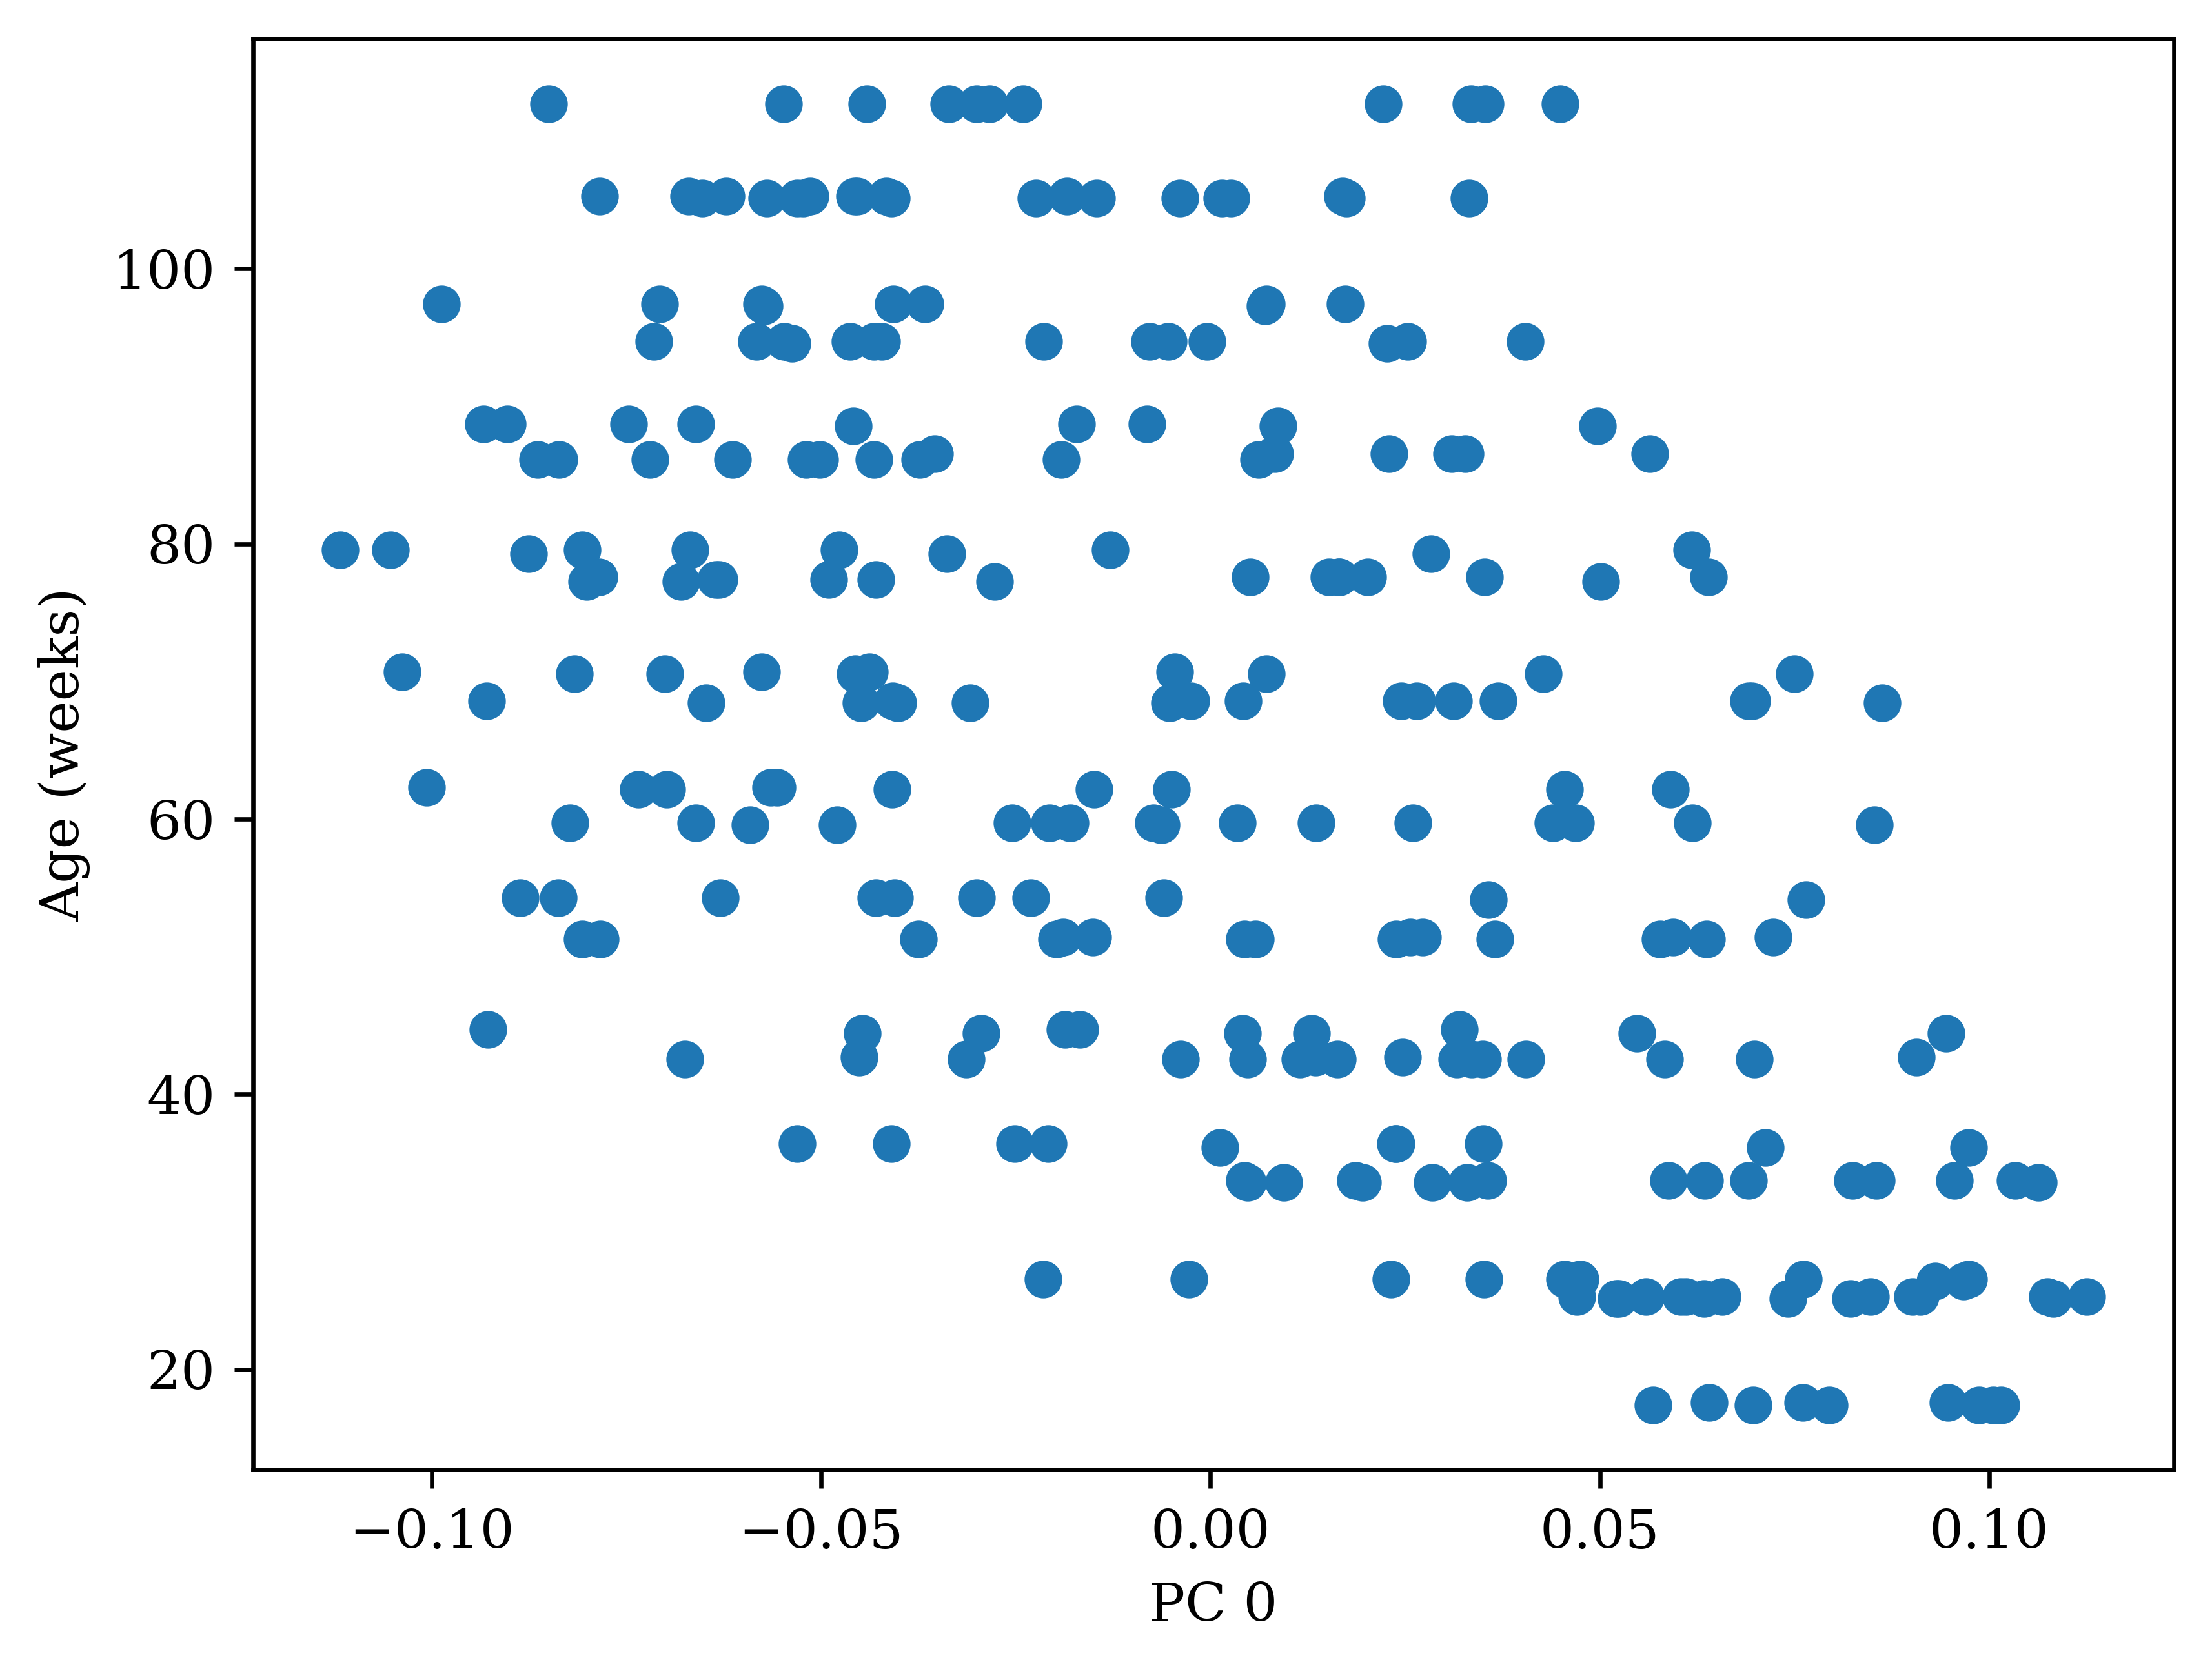

In [31]:
plt.scatter(latents[:, 0], age_index(usage_mtx))
plt.xlabel("PC 0")
plt.ylabel("Age (weeks)")

In [23]:
pd.Series(latents[:, 0]).corr(pd.Series(age_index(usage_mtx)), method='spearman')

-0.5373901823830519

In [89]:
pca = PCA(n_components=2)
ont_latents = pca.fit_transform(ont_df)
jax_latents = pca.transform(usage_mtx.reindex(columns=ont_df.columns, fill_value=0))
long_latents = pca.transform(long_df.reindex(columns=ont_df.columns, fill_value=0))

In [95]:
avg_long_val = pd.DataFrame(long_latents, columns=['pc0', 'pc1'], index=long_df.index)
avg_long_val['age_group'] = pd.qcut(age_index(avg_long_val), 25, labels=False)
avg_long_val.set_index('age_group', append=True, inplace=True)

In [83]:
avg_ont_val = pd.DataFrame(ont_latents, columns=['pc0', 'pc1'], index=ont_df.index).groupby('age').median(numeric_only=True)
smoother_df = pd.DataFrame(jax_latents, columns=['pc0', 'pc1'], index=usage_mtx.index).reset_index()
smoother_df['age_group'] = np.floor(smoother_df['age'])
pos = smoother_df.groupby('age_group').median(numeric_only=True).drop(columns=['age'])

In [96]:
cmap = plt.get_cmap("Reds", lut=110)
cmap_ont = plt.get_cmap("Blues", lut=110)
cmap_long = plt.get_cmap("Greens", lut=110)

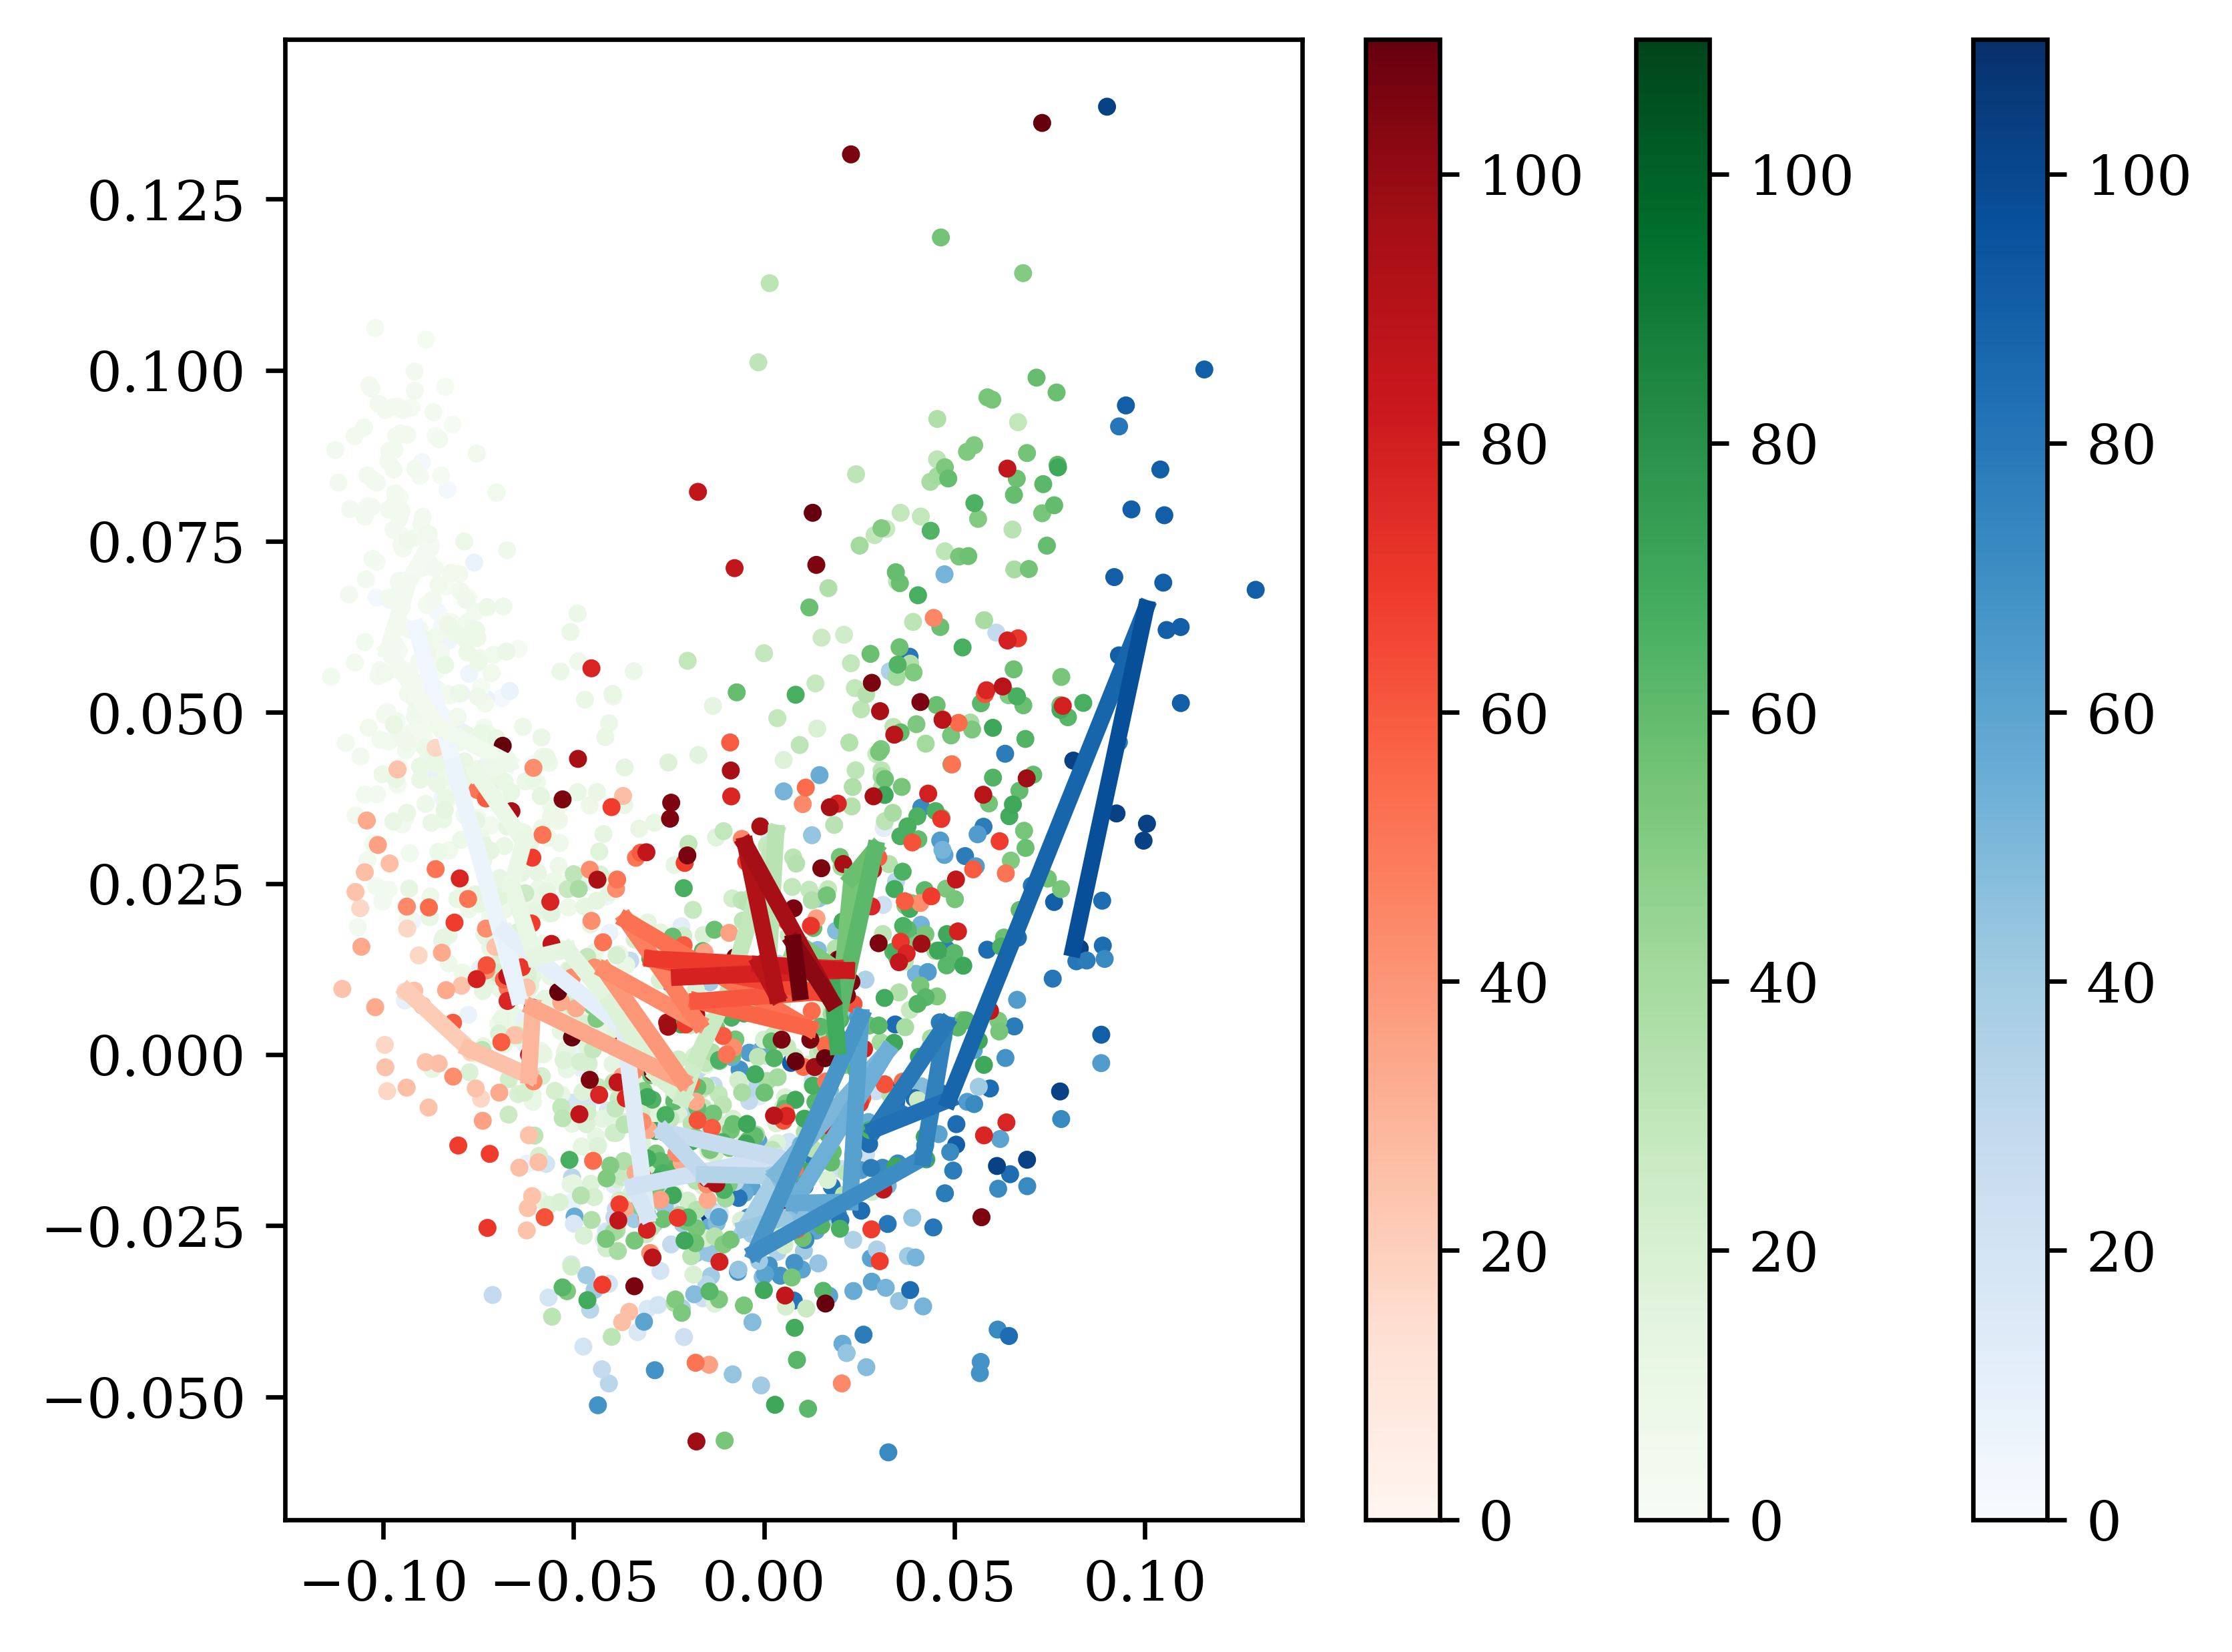

In [99]:
plt.scatter(*ont_latents.T, c=age_index(ont_df), cmap="Blues", vmax=110, vmin=0, s=5)
plt.colorbar()
plt.scatter(
    *long_latents.T, c=age_index(long_df) / 7, cmap="Greens", vmax=110, vmin=0, s=5
)
plt.colorbar()
plt.scatter(*jax_latents.T, c=age_index(usage_mtx), cmap="Reds", vmax=110, vmin=0, s=5)
plt.colorbar()
for (idx, row), (idx2, row2) in sliding_window(2, avg_ont_val.iterrows()):
    plt.plot(
        [row["pc0"], row2["pc0"]],
        [row["pc1"], row2["pc1"]],
        c=cmap_ont((idx + idx2) / 220),
        lw=3,
    )
for (age1, _df1), (age2, _df2) in sliding_window(2, avg_long_val.groupby("age_group")):
    age_low = pd.Series(age_index(_df1)).mean() / 7
    age_high = pd.Series(age_index(_df2)).mean() / 7
    latent_low = _df1.mean()
    latent_high = _df2.mean()
    plt.plot(
        [latent_low["pc0"], latent_high["pc0"]],
        [latent_low["pc1"], latent_high["pc1"]],
        c=cmap_long((age_low + age_high) / 220),
        lw=3,
    )
for (idx, row), (idx2, row2) in sliding_window(2, pos.iterrows()):
    plt.plot(
        [row["pc0"], row2["pc0"]],
        [row["pc1"], row2["pc1"]],
        c=cmap((idx + idx2) / 220),
        lw=3,
    )

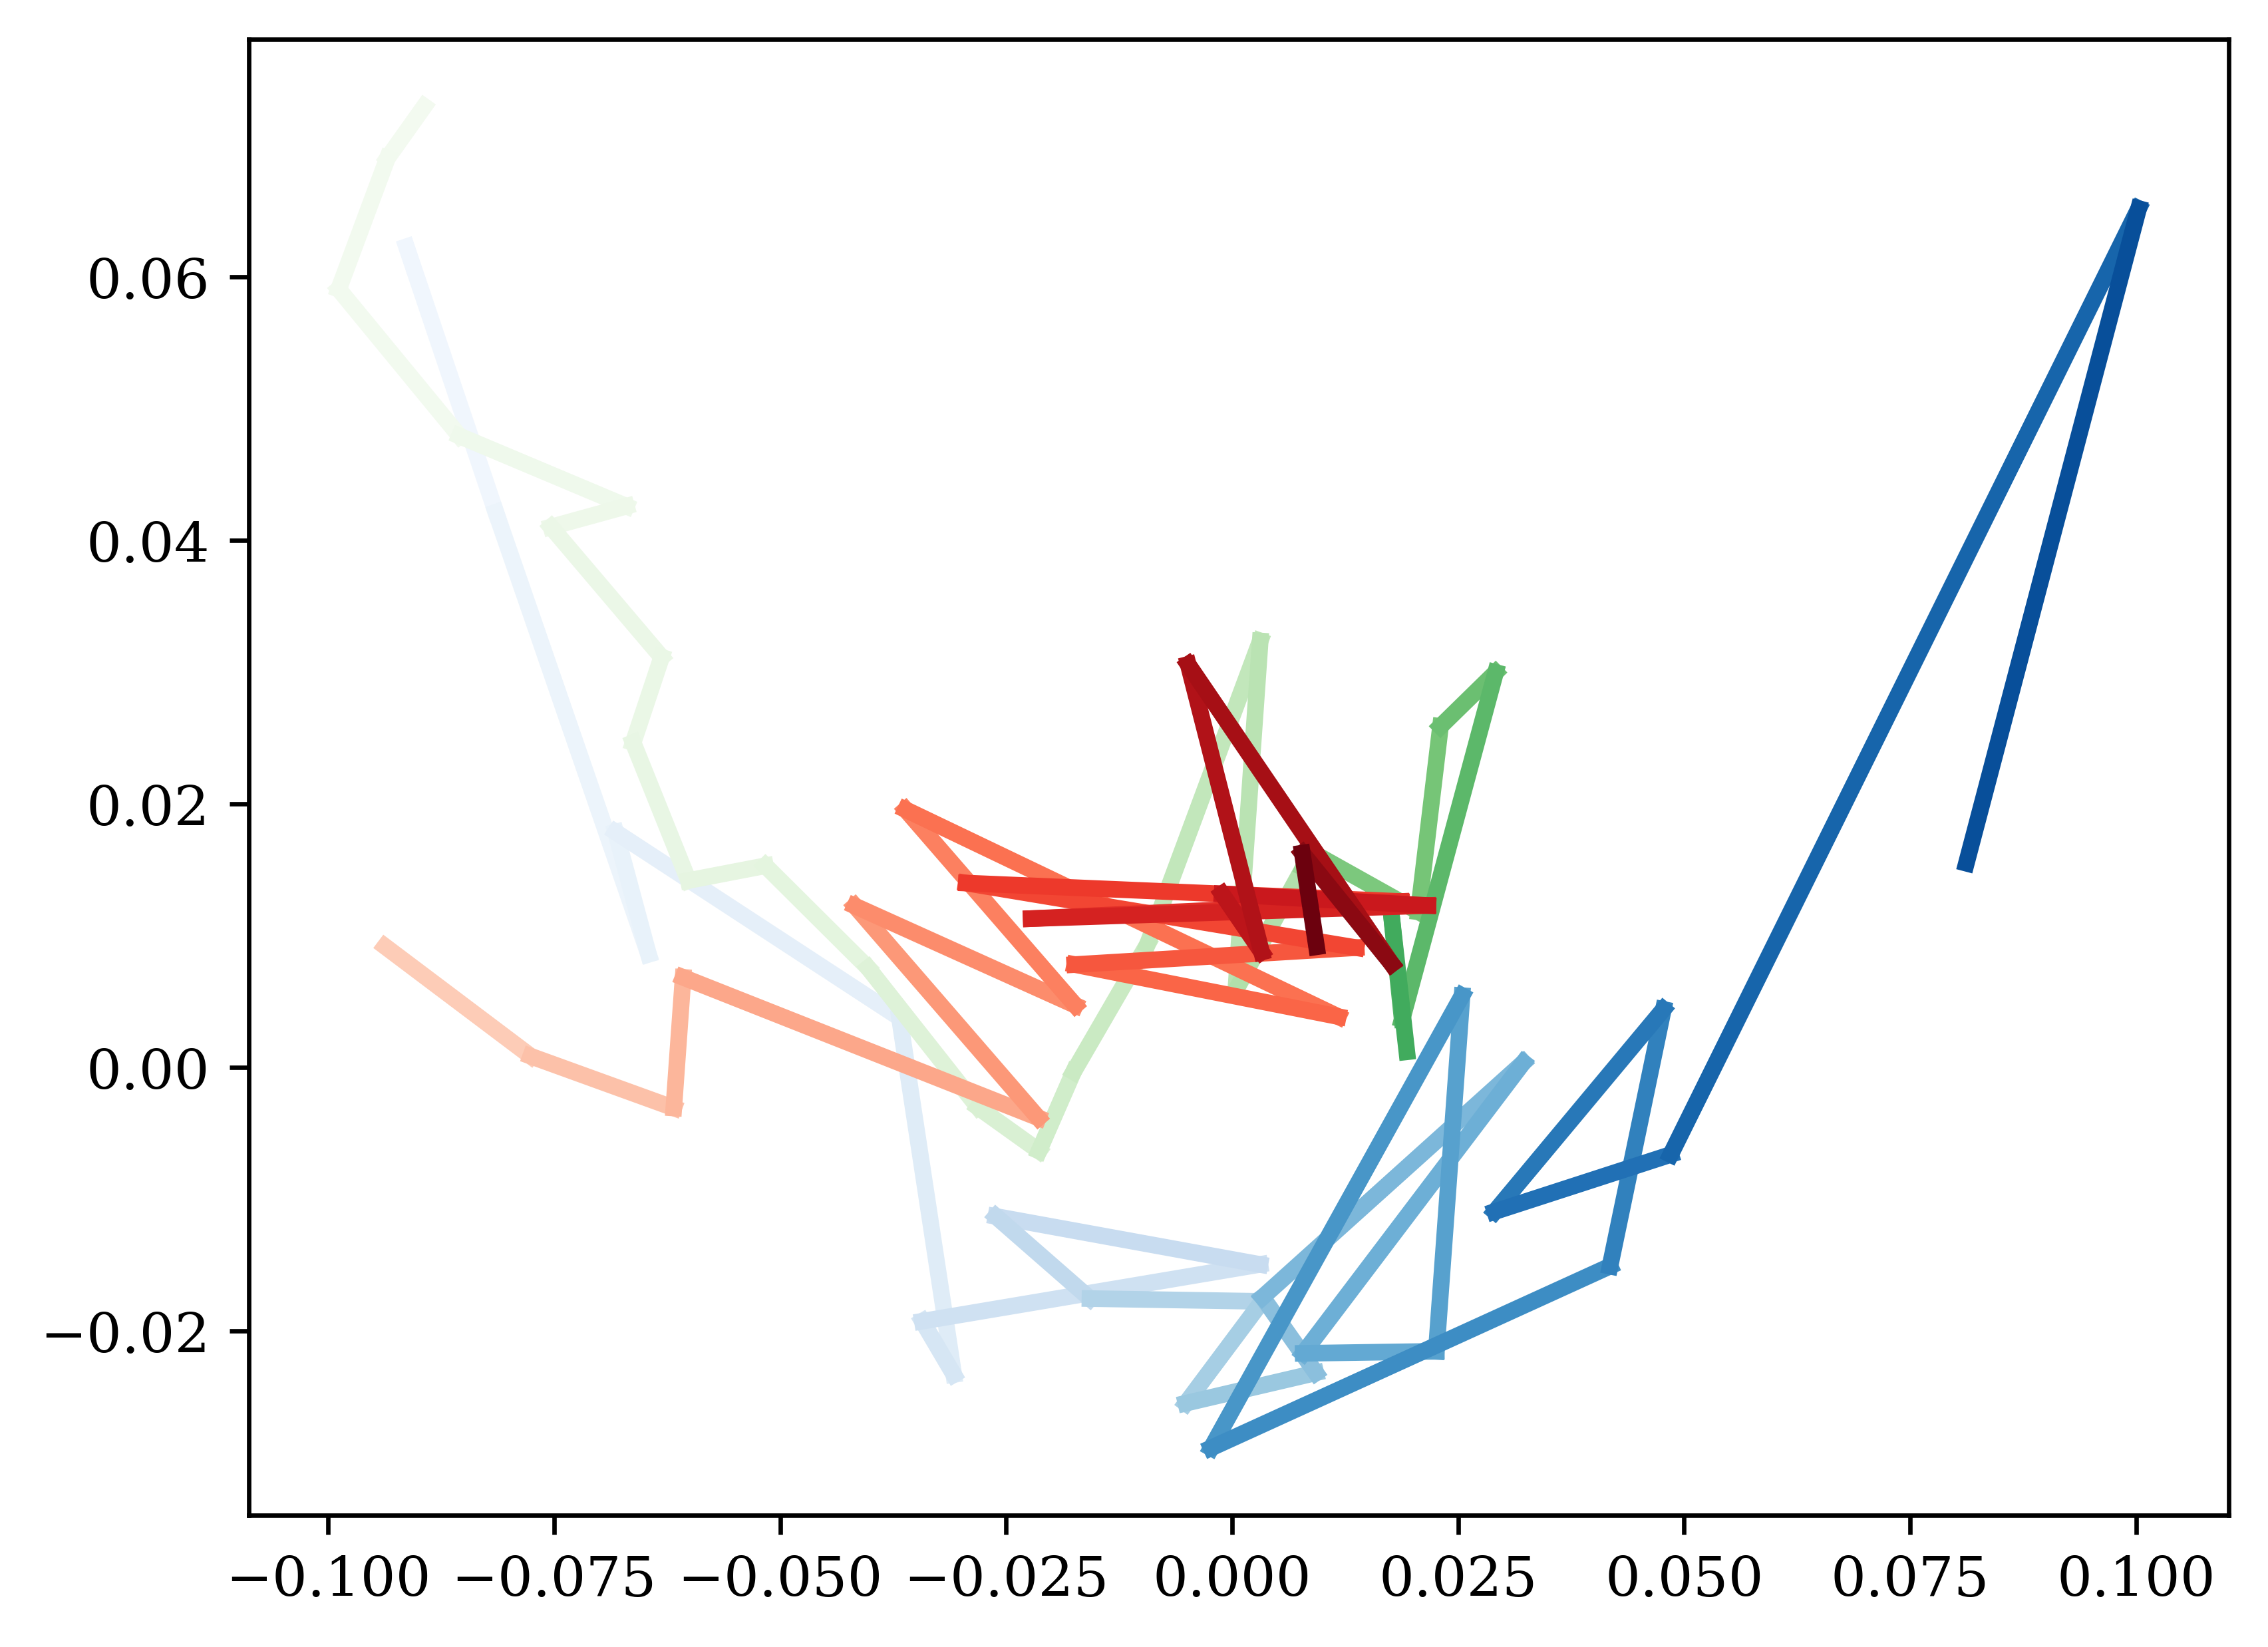

In [100]:
for (idx, row), (idx2, row2) in sliding_window(2, avg_ont_val.iterrows()):
    plt.plot(
        [row["pc0"], row2["pc0"]],
        [row["pc1"], row2["pc1"]],
        c=cmap_ont((idx + idx2) / 220),
        lw=3,
    )
for (age1, _df1), (age2, _df2) in sliding_window(2, avg_long_val.groupby("age_group")):
    age_low = pd.Series(age_index(_df1)).mean() / 7
    age_high = pd.Series(age_index(_df2)).mean() / 7
    latent_low = _df1.mean()
    latent_high = _df2.mean()
    plt.plot(
        [latent_low["pc0"], latent_high["pc0"]],
        [latent_low["pc1"], latent_high["pc1"]],
        c=cmap_long((age_low + age_high) / 220),
        lw=3,
    )
for (idx, row), (idx2, row2) in sliding_window(2, pos.iterrows()):
    plt.plot(
        [row["pc0"], row2["pc0"]],
        [row["pc1"], row2["pc1"]],
        c=cmap((idx + idx2) / 220),
        lw=3,
    )


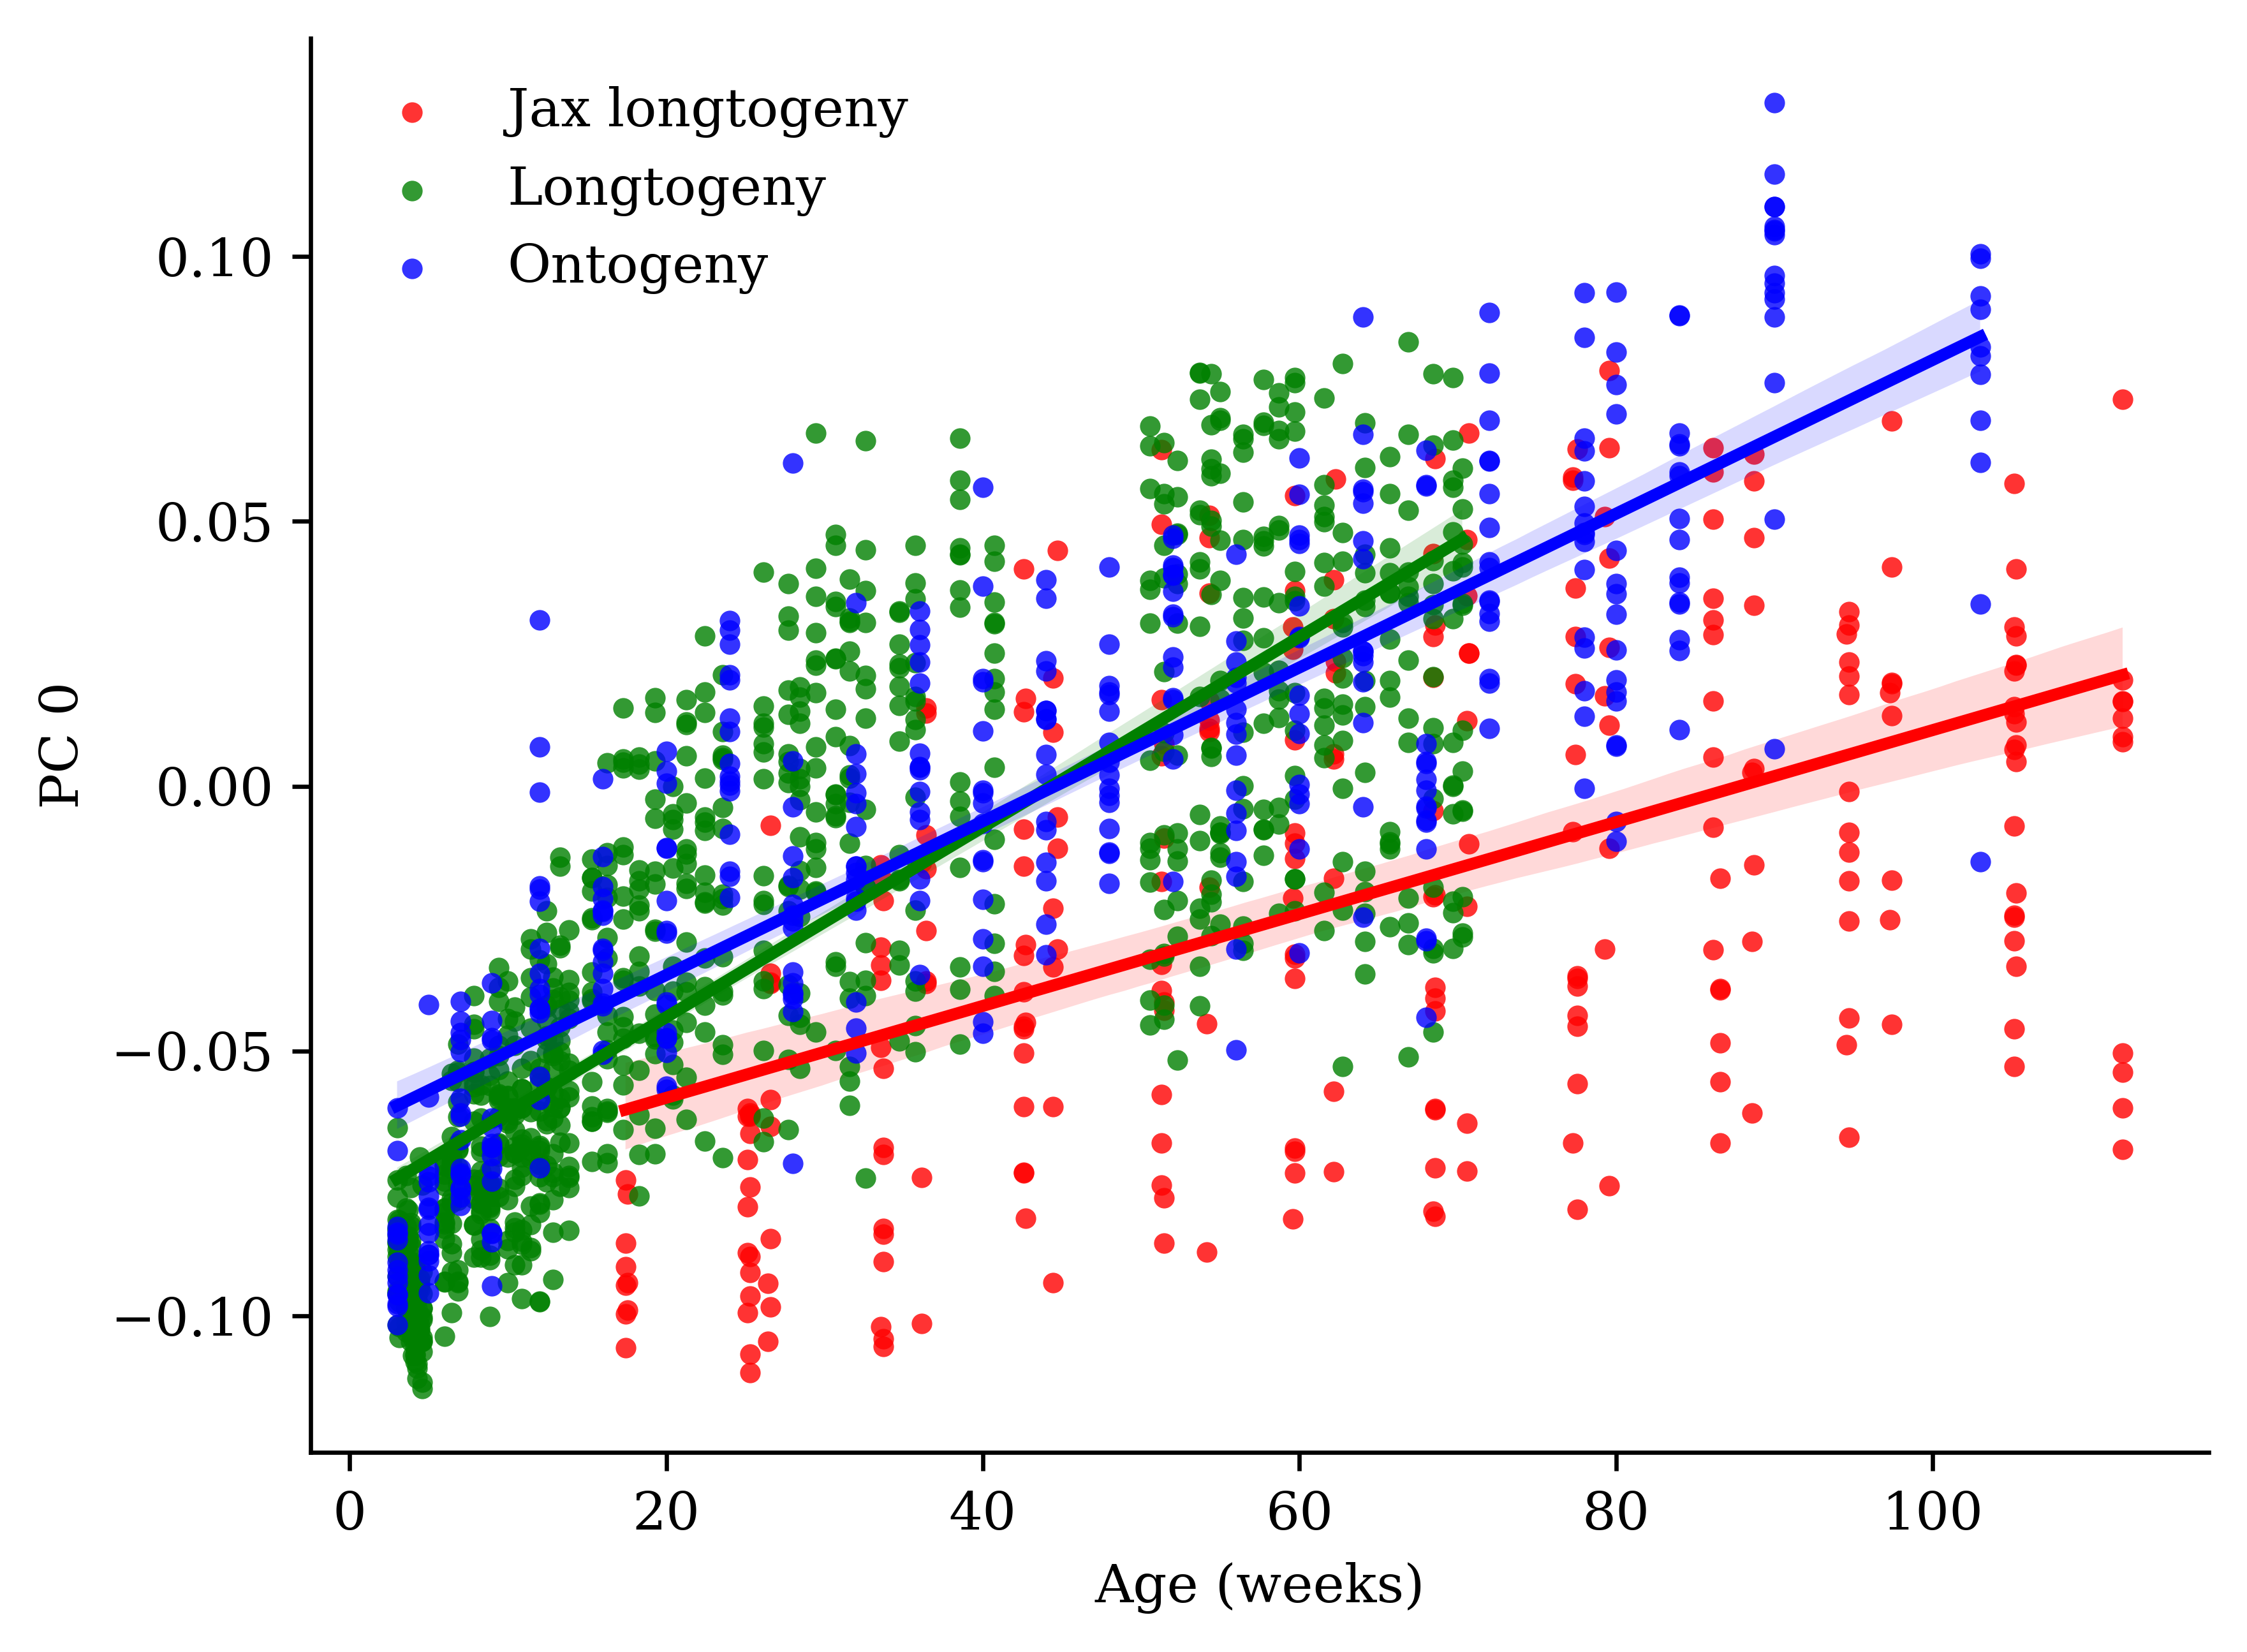

In [120]:
sns.regplot(
    x=age_index(usage_mtx),
    y=jax_latents[:, 0],
    color="red",
    scatter_kws=dict(linewidths=0, s=15),
    label="Jax longtogeny",
)
sns.regplot(
    x=age_index(long_df) / 7,
    y=long_latents[:, 0],
    color="green",
    scatter_kws=dict(linewidths=0, s=15),
    label="Longtogeny",
)
ax = sns.regplot(
    x=age_index(ont_df),
    y=ont_latents[:, 0],
    color="blue",
    scatter_kws=dict(linewidths=0, s=15),
    label="Ontogeny",
)
ax.set(ylabel="PC 0", xlabel="Age (weeks)")
plt.legend(frameon=False)
sns.despine()